In [ ]:
%%file speedtests.py
from skimage.io import imread
import glob
import time
import cupy as cp
import matplotlib.pyplot as plt

def image_generator(image_paths, batch_size):
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]

        # Measure the time taken to read the images
        t1 = time.perf_counter()
        img_list = [imread(path) for path in batch_paths]
        t2 = time.perf_counter()

        # Measure the time taken to convert the list to a CuPy array
        t3 = time.perf_counter()
        batch_imgs = cp.array(img_list, dtype=cp.float32)
        t4 = time.perf_counter()
        print(f"Time taken to convert to CuPy array: {t4 - t3} seconds")

        # t3 = time.perf_counter()
        # batch_imgs = cp.random.rand(batch_size, 4224, 4224, dtype=cp.float32)
        # t4 = time.perf_counter()

        print(f"Time taken to read images: {t2 - t1} seconds")
        print(f"Time taken to create arrays: {t4-t3} seconds")

        yield batch_imgs


def main(batch_size=20):
    image_paths = glob.glob('/nobackup/kp276129/test/slice_10*') # 100 4k tif
    batch_times = []
    individual_times = []

    # 1 loop per batch
    for batch_imgs in image_generator(image_paths, batch_size):

        t0 = time.perf_counter()
        imgs_corr = cp.fft.fft2(batch_imgs)
        t1 = time.perf_counter()

        cp.fft.config.get_plan_cache().clear()
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()

        imgs_corr_2 = cp.zeros((batch_size, 4224, 4224), dtype=cp.complex64)
        t2 = time.perf_counter()
        for i, img in enumerate(batch_imgs):
            imgs_corr_2[i] = cp.fft.fft2(img)
        t3 = time.perf_counter()

        cp.fft.config.get_plan_cache().clear()
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()

        batch_times.append(t1-t0)
        individual_times.append(t3-t2)

    return batch_times, individual_times

    print(f"Time taken for batch FFT: {t1-t0} seconds")
    print(f"Time taken for individual FFT: {t3-t2} seconds")

    # imgs = cp.array([skimage.io.imread(img) for img in imgs]) # this is taking 2m for 100 4k images
    # imgs = cp.random.rand(2000, 2048, 2048)

    # Check that the results are the same
    # assert cp.allclose(imgs_corr, imgs_corr_2), "The batch FFT results do not match the individual FFT results"

In [ ]:
from speedtests import main
import matplotlib.pyplot as plt

batch_sizes = [20]
batch_time_per_image = []
individual_time_per_image = []

for batch_size in batch_sizes:
    batch_time, individual_times = main(batch_size)
    num_images = batch_size * len(batch_time)
    batch_time_per_image.append(sum(batch_time)/num_images)
    individual_time_per_image.append(sum(individual_times)/num_images)

print(f"Total Time for Batch FFT: {sum(batch_time)}")
print(f"Total Time for Individual FFT:  {sum(individual_times)}")

plt.plot(batch_sizes, batch_time_per_image, label='Batch FFT')
plt.plot(batch_sizes, individual_time_per_image, label='Individual FFT')
plt.xlabel('Batch Size')
plt.ylabel('Time per Image (s)')
plt.legend()
plt.show()


In [ ]:
# Reading Speed Test

from skimage.io import imread
import glob
import time
import cupy as cp

image_paths = glob.glob('/nobackup/kp276129/test/slice_100*') # 10 4k tif

# Read 100 images
t1 = time.perf_counter()
imgs = [imread(img) for img in image_paths]
t2 = time.perf_counter()

print(f"Time taken to read {len(image_paths)} images: {t2 - t1} seconds")

TIFFReadDirectory: Warning, Unknown field with tag 51023 (0xc74f) encountered.
TIFFReadDirectory: Warning, TIFFReadDirectory: Unknown field with tag 51023 (0xc74f) encounteredTIFFReadDirectory: .
Warning, TIFFReadDirectory: TIFFReadDirectory: Warning, TIFFReadDirectory: Unknown field with tag 51023 (0xc74f) encounteredWarning, .
Warning, Unknown field with tag 51023 (0xc74f) encountered.
TIFFReadDirectory: Unknown field with tag 51023 (0xc74f) encounteredWarning, .
Unknown field with tag 51023 (0xc74f) encountered.
Warning, Unknown field with tag 51023 (0xc74f) encountered.
Unknown field with tag 51023 (0xc74f) encountered.
TIFFReadDirectory: Warning, TIFFReadDirectory: Warning, Unknown field with tag 51023 (0xc74f) encountered.
Unknown field with tag 51023 (0xc74f) encountered.


Time taken to read 10 images: 0.3592856489121914 seconds
{'shape': (4224, 4224, 1), 'strides': None, 'typestr': '<u2', 'data': (12954140672, False), 'version': 3, 'stream': 1}
0 65472 uint16


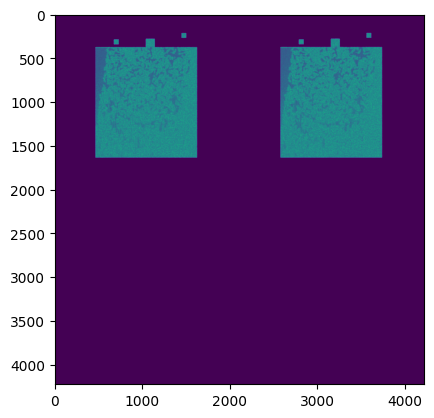

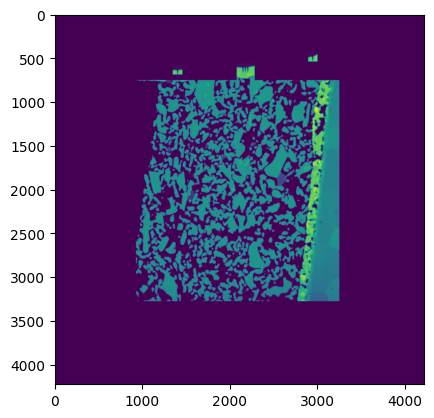

In [13]:
# Reading Speed Test Nvimgcodec

from nvidia import nvimgcodec
import glob
import time
import cupy as cp
from matplotlib import pyplot as plt
from tifffile import imread

image_paths = glob.glob('/nobackup/kp276129/test/slice_100*') # 10 4k tif
data_list = []

# Read 100 images
t1 = time.perf_counter()
params = nvimgcodec.DecodeParams(color_spec=nvimgcodec.ColorSpec.UNCHANGED, allow_any_depth=True)
dec = nvimgcodec.Decoder()
imgs = dec.read(image_paths, params)
t2 = time.perf_counter()
print(f"Time taken to read {len(image_paths)} images: {t2 - t1} seconds")

img1=imgs[0]
print(img1.__cuda_array_interface__)
img1=cp.asarray(img1) #.get().squeeze()
print(img1)
# print(img1.min(), img1.max(), img1.dtype)
plt.figure()
plt.imshow(img1)

img0 = imread(image_paths[0])
print(img0.min() ,img0.max(), img0.dtype)
plt.figure()
plt.imshow(img0)
# print(img0.max())
# assert cp.allclose(img0, img1), "The images do not match"


In [ ]:
import cupy as cp

imgs_cp = []

# Converting 10 images to CuPy arrays
t3 = time.perf_counter()
for img in imgs:
    imgs_cp.append(cp.asarray(img))
t4 = time.perf_counter()

for img in imgs_cp:
    plt.imshow(cp.asnumpy(img))
    plt.show()

print(f"Time taken to convert {len(imgs)} images to CuPy arrays: {t4 - t3} seconds")

In [ ]:
import sys
sys.path.append('..')
from src.pyvsnr import vsnr2d

filters=[{'name':'Dirac', 'noise_level':0.35}]

# Time to apply vsnr2d to 10 images one by one
t5 = time.perf_counter()
for img in imgs_cp:
    vsnr2d(img, filters)
t6 = time.perf_counter()

print(f"Time taken to apply vsnr2d to {len(imgs)} images one by one: {t6 - t5} seconds")

In [ ]:
# Comparing batch processing vs individual processing on simple FFT

# Method 1 batch
t7 = time.perf_counter()
imgs_corr = cp.fft.fft2(imgs_cp)
t8 = time.perf_counter()

print(f"Time taken to apply FFT to {len(imgs)} images in batch: {t8 - t7} seconds")

# Method 2 individual
imgs_corr_2 = cp.zeros((len(imgs), 4224, 4224), dtype=cp.complex64)
t9 = time.perf_counter()
for i, img in enumerate(imgs_cp):
    imgs_corr_2[i] = cp.fft.fft2(img)
t10 = time.perf_counter()

print(f"Time taken to apply FFT to {len(imgs)} images individually: {t10 - t9} seconds")

In [ ]:
# imread_collection vs imread : Same

from skimage.io import imread, imread_collection
import cupy as cp
import glob
import time

image_paths = glob.glob('/nobackup/kp276129/test/slice_100*') # 100 4k tif

# Method 1 : Read with imread_collection
t1 = time.perf_counter()
imgs1 = list(imread_collection(image_paths))
t2 = time.perf_counter()
print(f"Time taken to read images with imread_collection: {t2 - t1} seconds")

# Method 2 : Read with imread
t3 = time.perf_counter()
imgs2 = [imread(path) for path in image_paths]
t4 = time.perf_counter()
print(f"Time taken to read images with imread: {t4 - t3} seconds")


In [ ]:
%load_ext memory_profiler
from speedtests import main

%mprun -f main main()

In [ ]:
import sys
sys.path.append('../')
import src.pyvsnr as pyvsnr
import cupy as cp
import cProfile

img = cp.random.rand(4200, 4200)
filters=[{'name':'Dirac', 'noise_level':0.35}]

cProfile.run('pyvsnr.vsnr2d(img, filters)')


In [ ]:
# Reading Speed Test

import nvtiff
from skimage.io import imread
import glob
import time

image_paths = glob.glob('/nobackup/kp276129/test/slice_100*') # 100 4k tif

# Read 100 images
t1 = time.perf_counter()
imgs = []
for img in image_paths:
    f = nvtiff.nvTiffFile(0, img, use_pinned_mem=True)
    nvTiff_imgs_gpu = nvtiff.decode(f, return_single_array=True)
    imgs.append(nvTiff_imgs_gpu)
t2 = time.perf_counter()

print(imgs)

# Converting 10 images to CuPy arrays
t3 = time.perf_counter()
imgs_cp = cp.array(imgs, dtype=cp.float32)
t4 = time.perf_counter()

print(f"Time taken to read {len(image_paths)} images: {t2 - t1} seconds")
print(f"Time taken to convert {len(imgs)} images to CuPy arrays: {t4 - t3} seconds")